In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.utils import read_from_pickle
import jax.numpy as jnp
from ff_energy.ffe.plot import plot_energy_MSE, plot_ff_fit
from ff_energy.ffe.structure import atom_key_pairs
from ff_energy.ffe.potential import LJ, akp_indx
from ff_energy.ffe.ff import FF
from ff_energy.ffe.ff_fit import LJ_bound, load_ff, fit_func, fit_repeat
from ff_energy.ffe.data import pairs_data
from ff_energy.ffe.utils import pickle_output, read_from_pickle, str2int




In [2]:
sig_bound = (0.001, 2.5)
ep_bound = (0.001, 2.5)
chg_bound = (100,2000)

CHGPEN_bound = [(chg_bound),(chg_bound),(chg_bound),(chg_bound),(0,2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), 
            (1, 8), (6, 20))

In [3]:
#  example
# ffpkl = "ECOL_pbe0dz_FOE.ff.pkl"
ffpkl = "pc_pbe0dz_FOE.ff.pkl"

In [4]:
_c = next(read_from_pickle(f"ff/{ffpkl}"))
_c

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


FF: LJ water_cluster ELEC harmonic first_order_energy (jax_coloumb: True)

In [5]:
_c.intE = "ECOL"
_c.set_targets()
# _c.targets
# _c.data.ECOL
# _c.data.ELEC

In [6]:
fit_repeat(_c, 
           1, 
           f"{ffpkl}_chgpen",
           bounds = CHGPEN_bound,
           loss="chgpen",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [7]:
resx = _c.opt_parm 

loss = _c.get_loss_chgpen(resx)
loss
resx

array([1931.87974836,  785.88904383, 1068.90142352, 1352.59359003,
        312.80553937])

In [8]:
np.sqrt(loss)

14.346787

In [9]:
# _c.eval_jax_chgpen(resx ) 

1.044724416776137e-144


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 205.83032225979161,
  'RMSE': 14.346787872544558,
  'R': 0.8558693701468393,
  'RS': 0.8397476149904599,
  'n': 500,
  'slope': 0.9371525781532094,
  'intercept': -6.035412654595788})

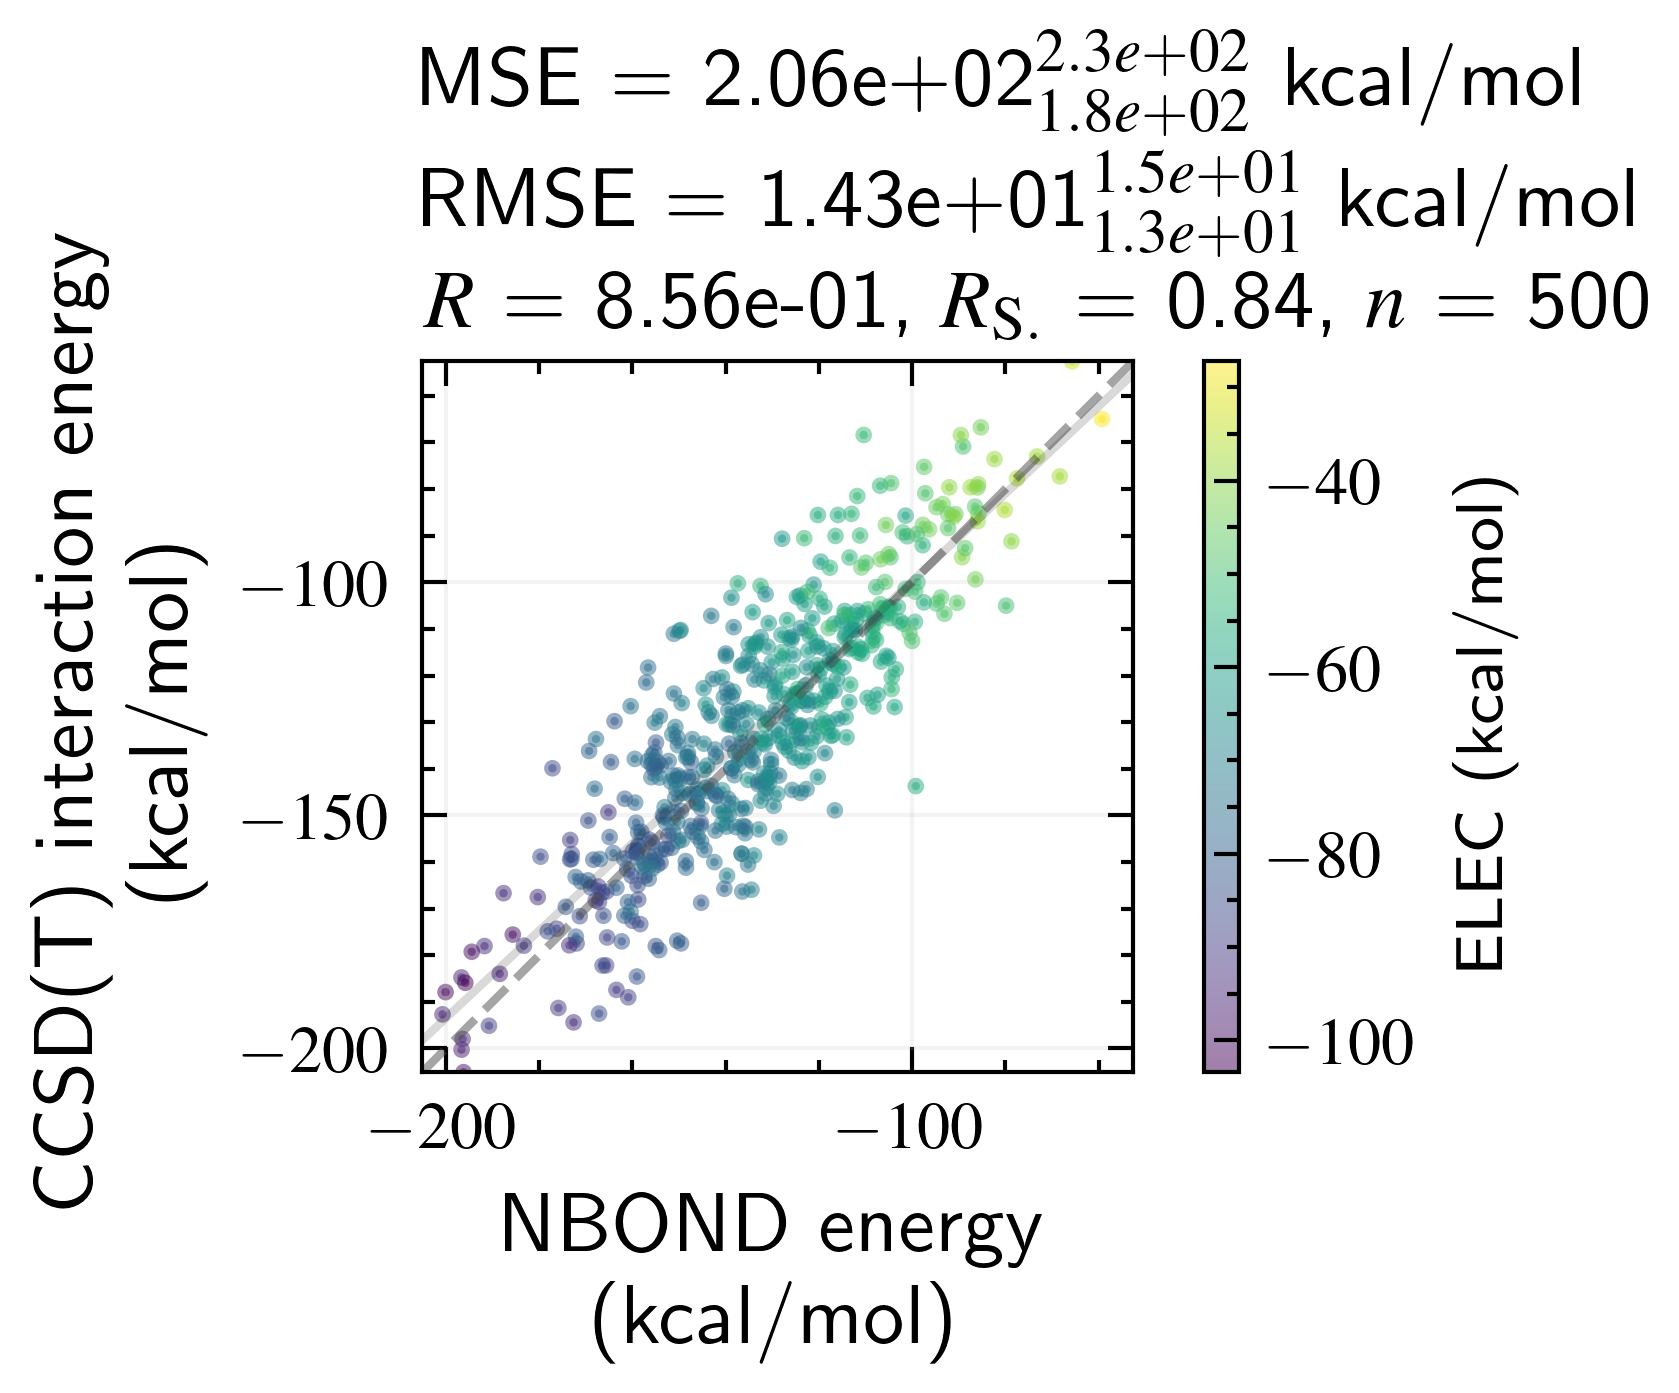

In [10]:
# _c.eval_jax_chgpen(resx ) 
_c.data["fit_ECOL"] = _c.eval_jax_chgpen(resx ) + _c.data.ELEC
plot_energy_MSE(_c.data, "ECOL", "fit_ECOL",  elec = "ELEC")

2.5608014994665487e-245


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 4527.964453647834,
  'RMSE': 67.29015123811087,
  'R': 0.9457588017676065,
  'RS': 0.9416012384049537,
  'n': 500,
  'slope': 0.4930125400388275,
  'intercept': -1.8806212356120398})

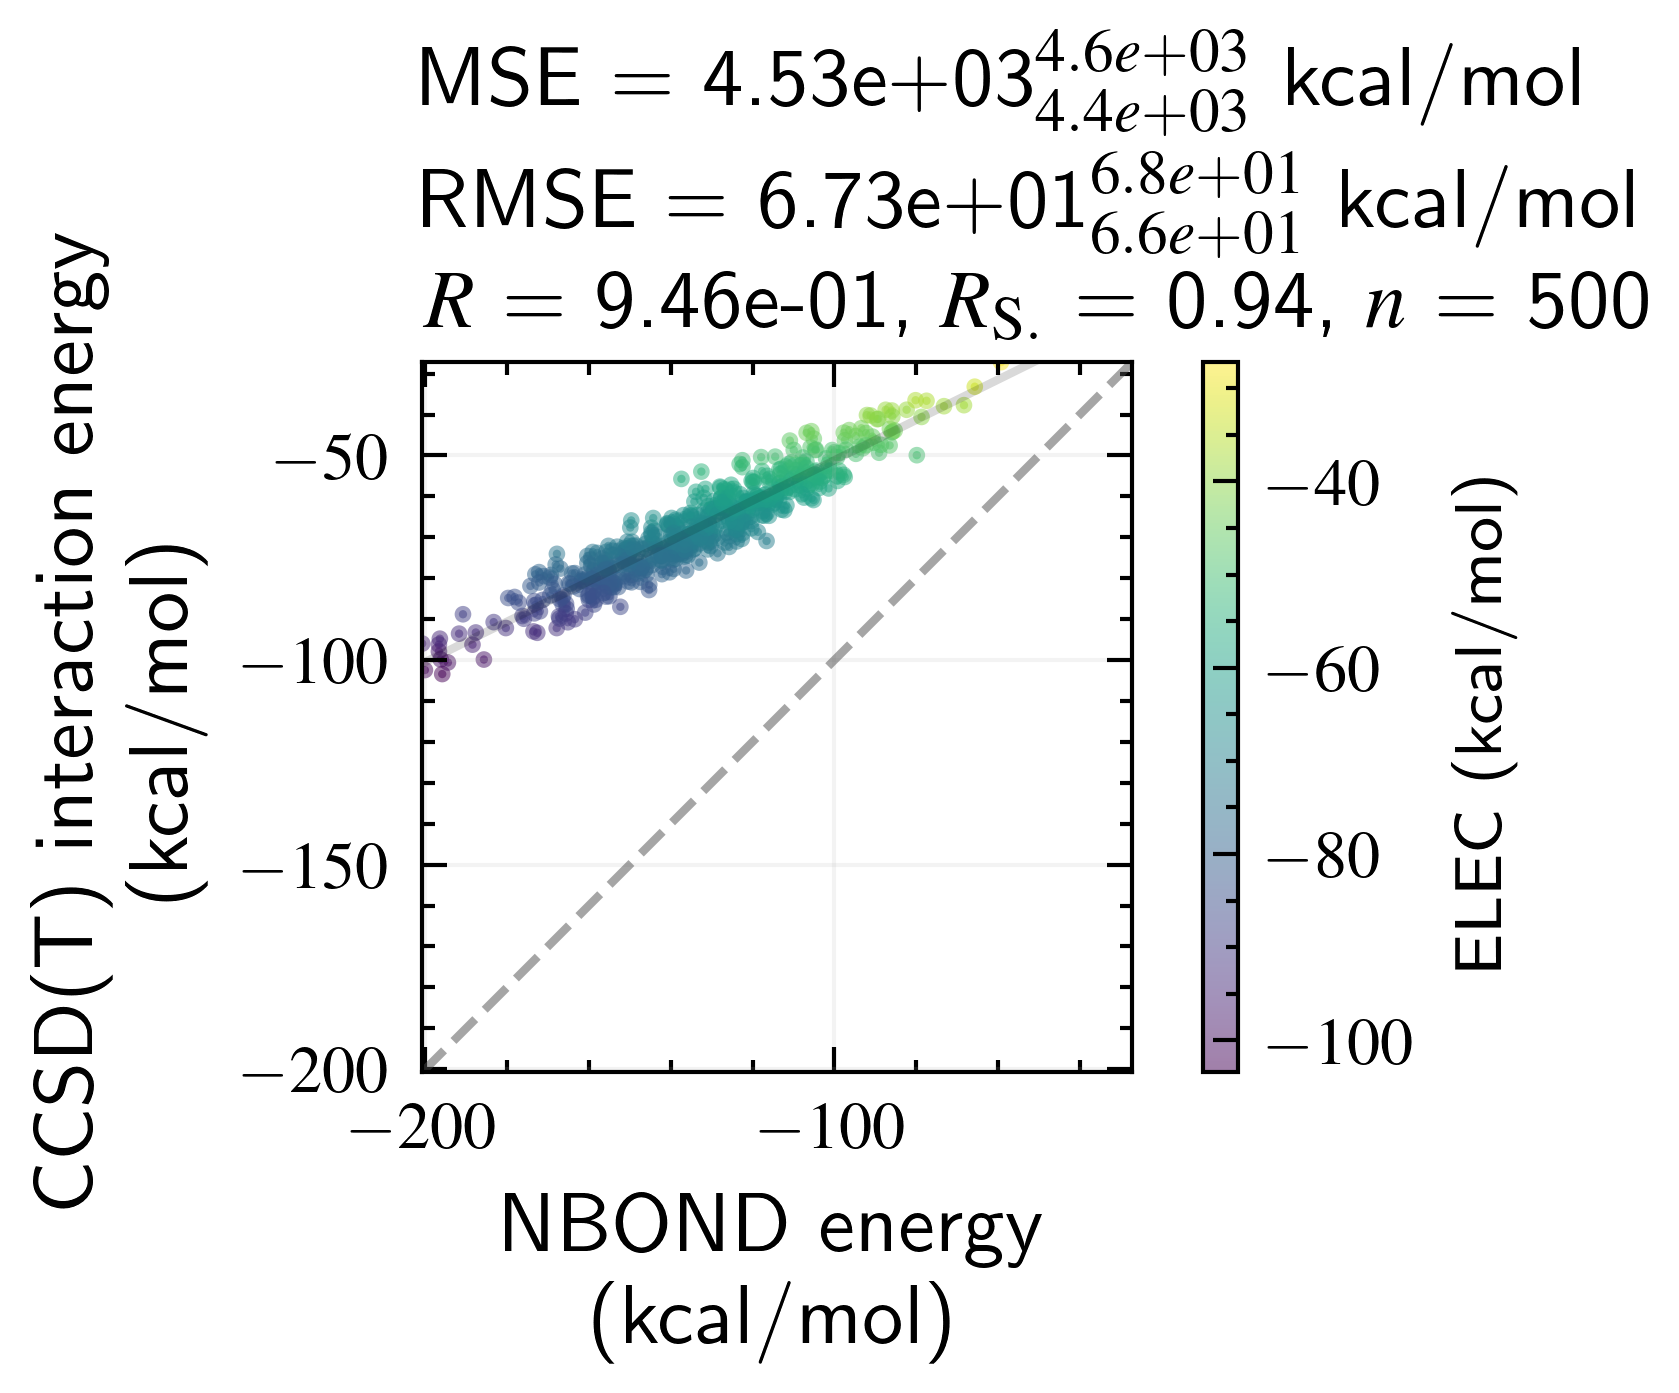

In [11]:
plot_energy_MSE(_c.data, "ECOL", "ELEC",  elec = "ELEC")

In [12]:
pickle_output(_c, "ff/fit_ECOL_pc_FOE")

#  LJ fit


In [13]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_pc_FOE.pkl"))
LJFF.elec = "fit_ECOL"
LJFF

FF: LJ water_cluster fit_ECOL harmonic ECOL (jax_coloumb: True)

In [14]:
# _c.targets

In [15]:
fit_repeat(LJFF, 
           3, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [16]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
3,35.321651,406,716,0,True,Optimization terminated successfully.,"[0.4994134975954001, 1.1254357502073202, 2.5, ...","([[0.4994134975954001, 1.1254357502073202, 2.5..."
1,35.321697,351,610,0,True,Optimization terminated successfully.,"[0.49953598353907924, 1.1253602158967575, 2.5,...","([[0.49953598353907924, 1.1253602158967575, 2...."
2,35.341915,336,603,0,True,Optimization terminated successfully.,"[0.4995930540699368, 1.1255728037287074, 2.493...","([[0.4995930540699368, 1.1255728037287074, 2.4..."
0,205.830322,116,293,0,True,Optimization terminated successfully.,"[1931.879748363418, 785.889043829854, 1068.901...","([[1931.879748363418, 785.889043829854, 1068.9..."


#  DE fit


In [17]:
# _c = next(read_from_pickle(f"ff/{ffpkl[:-4]}_chgpen.pkl"))
DEFF = next(read_from_pickle(f"ff/fit_ECOL_pc_FOE.pkl"))
DEFF.elec = "fit_ECOL"
DEFF

FF: LJ water_cluster fit_ECOL harmonic ECOL (jax_coloumb: True)

In [21]:
fit_repeat(DEFF, 
           10, 
           "test",
           bounds = DE_bound,
           loss="jax_de",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [22]:
pd.DataFrame(DEFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
4,31.262032,927,1516,0,True,Optimization terminated successfully.,"[0.374498702735363, 1.2886660168334374, 2.4999...","([[0.374498702735363, 1.2886660168334374, 2.49..."
2,31.262457,1085,1746,0,True,Optimization terminated successfully.,"[0.37387313229101116, 1.2886538162951076, 2.49...","([[0.37387313229101116, 1.2886538162951076, 2...."
7,31.262493,972,1562,0,True,Optimization terminated successfully.,"[0.37422833445116266, 1.2888955240041915, 2.49...","([[0.37422833445116266, 1.2888955240041915, 2...."
13,31.270956,763,1304,0,True,Optimization terminated successfully.,"[0.37424993617874547, 1.2886397243453989, 2.49...","([[0.37424993617874547, 1.2886397243453989, 2...."
8,31.318279,1161,1857,0,True,Optimization terminated successfully.,"[0.37892380209533005, 1.2863474366021261, 2.49...","([[0.37892380209533005, 1.2863474366021261, 2...."
11,31.420248,351,627,0,True,Optimization terminated successfully.,"[0.3752959888439522, 1.2923959650386625, 2.499...","([[0.3752959888439522, 1.2923959650386625, 2.4..."
6,33.031277,1154,1875,0,True,Optimization terminated successfully.,"[0.38740193965252623, 1.277687453586629, 2.350...","([[0.38740193965252623, 1.277687453586629, 2.3..."
10,33.601082,826,1309,0,True,Optimization terminated successfully.,"[0.4356463857138131, 1.1958411352538136, 2.499...","([[0.4356463857138131, 1.1958411352538136, 2.4..."
3,33.603291,896,1425,0,True,Optimization terminated successfully.,"[0.43572979228557207, 1.1958541772360125, 2.49...","([[0.43572979228557207, 1.1958541772360125, 2...."
1,33.685852,842,1383,0,True,Optimization terminated successfully.,"[0.41806757187565113, 1.2492759452101923, 2.49...","([[0.41806757187565113, 1.2492759452101923, 2...."


In [23]:
# np.sqrt(31.166512)

5.58269755584162

In [24]:
list(pd.DataFrame(\
                  _c.opt_results)\
     .sort_values("fun").x)[0]

array([1931.87974836,  785.88904383, 1068.90142352, 1352.59359003,
        312.80553937])